### LSTM Experiment - Maritime analytics Thesis

In [124]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from shapely.geometry import Point, LineString
from datetime import timedelta
from pymeos import *

import geopandas as gpd
import movingpandas as mpd
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import contextily as ctx

pymeos_initialize()

In [107]:
def create_point(row):
    return TGeogPointInst(string=f"{row['geometry']}@{row.name}")

def extract_wkt_from_traj(trajectory):
    res = "["
    for row in trajectory.df.iloc():
        res += f'{row.geometry.wkt}@{row.name},'
    res = res[:-1] + ']'
    return res

def create_sequence(trajectory):
    wkt = extract_wkt_from_traj(trajectory)
    return TGeogPointSeq(string=wkt)

In [268]:
def create_model(input_shape, sequence_length, prediction_features):
    model = tf.keras.models.Sequential([
        tf.keras.layers.LSTM(64, return_sequences=True, input_shape=input_shape),
        tf.keras.layers.LSTM(32, return_sequences=True),
        tf.keras.layers.LSTM(32),  # This layer returns a single vector, which might not be what you want for sequence prediction
        tf.keras.layers.Dropout(0.2),
        # Add a Dense layer with 'prediction_features' units for each timestep in the output sequence
        tf.keras.layers.RepeatVector(sequence_length),  # Prepares the last LSTM output to be repeated as input for the next layer
        tf.keras.layers.LSTM(32, return_sequences=True),  # Return sequences for the repeated vector
        tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(prediction_features))  # Apply Dense layer for each timestep
    ])
    return model

def create_sequences(data, sequence_length=30, prediction_steps=10):
    X, y = [], []
    data = data.sort_index()  # Ensure the data is sorted by time
    for mmsi in data['mmsi'].unique():
        mmsi_data = data[data['mmsi'] == mmsi][['sog', 'lat', 'lon']]
        for i in range(len(mmsi_data) - sequence_length - prediction_steps + 1):
            X.append(mmsi_data.iloc[i:i+sequence_length].values)
            y.append(mmsi_data.iloc[i+sequence_length:i+sequence_length+prediction_steps][['lat', 'lon']].values)
    return np.array(X), np.array(y)


def create_sequences_track_id(data, sequence_length=30, prediction_steps=10):
    X, y = [], []
    data = data.sort_index()  # Ensure the data is sorted by time
    
    # Loop over each unique track_id instead of mmsi
    for track_id in data['track_id'].unique():
        # Filter the data for the current track_id
        track_data = data[data['track_id'] == track_id][['sog', 'lat', 'lon']]
        
        # Generate sequences for this track
        for i in range(len(track_data) - sequence_length - prediction_steps + 1):
            X_seq = track_data.iloc[i:i+sequence_length].values
            y_seq = track_data.iloc[i+sequence_length:i+sequence_length+prediction_steps][['lat', 'lon']].values
            X.append(X_seq)
            y.append(y_seq)
            
    return np.array(X), np.array(y)

def get_train_test_val_split(df):
    # Step 1: Shuffle and split the track_ids
    unique_track_ids = df['track_id'].unique()
    np.random.shuffle(unique_track_ids)  # Randomly shuffle the track IDs
    
    # Calculate split sizes
    num_tracks = len(unique_track_ids)
    train_size = int(num_tracks * 0.6)
    test_size = int(num_tracks * 0.2)
    # Validation size is implicitly the remaining IDs
    
    # Assign track IDs to each split
    train_ids = unique_track_ids[:train_size]
    val_ids = unique_track_ids[train_size:train_size + test_size]
    test_ids = unique_track_ids[train_size + test_size:]
    
    # Step 2: Split the dataset based on the track_id assignments
    train_df = df[df['track_id'].isin(train_ids)]
    test_df = df[df['track_id'].isin(test_ids)]
    val_df = df[df['track_id'].isin(val_ids)]

    return train_df, test_df, val_df

def create_sequences_meos(data, sequence_length=10, prediction_steps=3):
    X, y = [], []
    data = data.sort_index()  # Ensure the data is sorted by time
    mmsi_data = data[['sog', 'lat', 'lon']]
    for i in range(len(mmsi_data) - sequence_length - prediction_steps + 1):
        X.append(mmsi_data.iloc[i:i+sequence_length].values)
        y.append(mmsi_data.iloc[i+sequence_length:i+sequence_length+prediction_steps][['lat', 'lon']].values)
    return np.array(X), np.array(y)

def create_sequences_meos_2(data, sequence_length=10, prediction_steps=3):
    X, y = [], []
    data = data.sort_index()  # Ensure the data is sorted by time
    mmsi_data = data[['lat', 'lon']]
    for i in range(len(mmsi_data) - sequence_length - prediction_steps + 1):
        X.append(mmsi_data.iloc[i:i+sequence_length].values)
        y.append(mmsi_data.iloc[i+sequence_length:i+sequence_length+prediction_steps][['lat', 'lon']].values)
    return np.array(X), np.array(y)

In [109]:
pdf = pd.read_csv('./data/aisinput.csv')
pdf.head()

,t,mmsi,latitude,longitude,sog
0,2021-01-08 00:00:00,265513270,57.05900,12.272388,0.0
1,2021-01-08 00:00:01,219027804,55.94244,11.866278,0.0
2,2021-01-08 00:00:01,265513270,57.05900,12.272388,0.0
3,2021-01-08 00:00:03,219027804,55.94244,11.866278,0.0
4,2021-01-08 00:00:04,265513270,57.05900,12.272388,0.0


In [110]:
gdf = gpd.GeoDataFrame(pdf.drop(['latitude', 'longitude'], axis=1),
                       geometry=gpd.points_from_xy(pdf.longitude, pdf.latitude), crs=4326)
gdf.head()

,t,mmsi,sog,geometry
0,2021-01-08 00:00:00,265513270,0.0,POINT (12.27239 57.05900)
1,2021-01-08 00:00:01,219027804,0.0,POINT (11.86628 55.94244)
2,2021-01-08 00:00:01,265513270,0.0,POINT (12.27239 57.05900)
3,2021-01-08 00:00:03,219027804,0.0,POINT (11.86628 55.94244)
4,2021-01-08 00:00:04,265513270,0.0,POINT (12.27239 57.05900)


In [111]:
ships = mpd.TrajectoryCollection(gdf, 'mmsi', t='t')

In [232]:
ship = ships.trajectories[1]
shipdf = ship.df.copy()

interval_starts = shipdf.resample('15T').asfreq().index
shipdf['interval_start'] = shipdf.index.floor('15T')
shipdf['track_id'] = shipdf['interval_start'].astype('category').cat.codes

# Now shipdf has a 'track_id' column with a unique ID for each 15-minute interval
shipdf.head(10)

/tmp/ipykernel_30195/945191312.py:4: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  interval_starts = shipdf.resample('15T').asfreq().index
/tmp/ipykernel_30195/945191312.py:5: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  shipdf['interval_start'] = shipdf.index.floor('15T')


,mmsi,sog,geometry,interval_start,track_id
t,,,,,
2021-01-08 00:00:01,219027804,0.0,POINT (11.86628 55.94244),2021-01-08,0
2021-01-08 00:00:03,219027804,0.0,POINT (11.86628 55.94244),2021-01-08,0
2021-01-08 00:00:05,219027804,0.0,POINT (11.86628 55.94244),2021-01-08,0
2021-01-08 00:00:07,219027804,0.0,POINT (11.86628 55.94244),2021-01-08,0
2021-01-08 00:00:09,219027804,0.0,POINT (11.86628 55.94244),2021-01-08,0
2021-01-08 00:00:11,219027804,0.0,POINT (11.86628 55.94244),2021-01-08,0
2021-01-08 00:00:13,219027804,0.0,POINT (11.86628 55.94244),2021-01-08,0
2021-01-08 00:00:15,219027804,0.0,POINT (11.86628 55.94244),2021-01-08,0
2021-01-08 00:00:16,219027804,0.0,POINT (11.86628 55.94245),2021-01-08,0


In [272]:
comparison = {'name': [], 'time': [], 'rmse': [], 'mape': [], 'mae': []}

In [273]:
import time

comparison["name"].append("MovingPandas")
timestr = ""

scaler = MinMaxScaler()

data =  shipdf.copy()
data['lon'] = shipdf['geometry'].x
data['lat'] = shipdf['geometry'].y

start = time.time()
data[['lat', 'lon']] = scaler.fit_transform(data[['lat', 'lon']])

train_df, test_df, val_df = get_train_test_val_split(data)

# Create dataset
X_train, y_train = create_sequences(train_df, sequence_length=30, prediction_steps=10)
X_test, y_test = create_sequences(test_df, sequence_length=30, prediction_steps=10)
X_val, y_val = create_sequences(val_df, sequence_length=30, prediction_steps=10)

# # Prepare and train the model
start = time.time()

sequence_length = 10
prediction_features = 2

model = create_model(X_train.shape[1:], sequence_length, prediction_features)

model.compile(optimizer='adam', loss='mae')

# Note: No need to reshape y_train or y_val, as model output and targets are already aligned
model.fit(X_train, y_train, epochs=3, validation_data=(X_val, y_val))

end = time.time() - start
timestr += f' Training Time: {end} seconds'
comparison["time"].append(timestr)

Epoch 1/3
711/711 [==============================] - 18s 20ms/step - loss: 0.0404 - val_loss: 0.0171
Epoch 2/3
711/711 [==============================] - 14s 19ms/step - loss: 0.0141 - val_loss: 0.0154
Epoch 3/3
711/711 [==============================] - 14s 20ms/step - loss: 0.0100 - val_loss: 0.0144


250/250 [==============================] - 3s 7ms/step


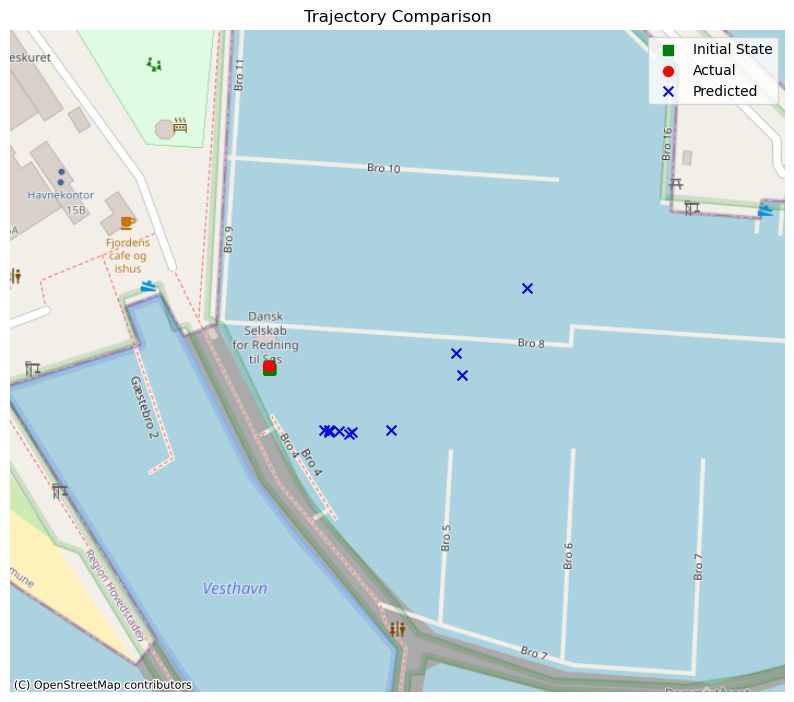

In [274]:
prediction_steps = 10

# Predict the test dataset
y_pred_scaled = model.predict(X_test)

# Assuming y_pred_scaled is now the prediction for the scaled Y values
# Inverse transform to get the original scale of lat and lon
y_pred_reshaped = y_pred_scaled.reshape(-1, 2)  # Reshape for scaler inverse transform
y_pred_inv = scaler.inverse_transform(y_pred_reshaped)  # Inverse transform to original scale
y_pred_inv = y_pred_inv.reshape(-1, prediction_steps, 2)  # Reshape back to the original prediction shape

# Prepare y_test similarly if not already in the correct shape and scale
y_test_reshaped = y_test.reshape(-1, 2)  # Reshape for scaler inverse transform
y_test_inv = scaler.inverse_transform(y_test_reshaped)  # Assuming y_test needs inverse transform
y_test_inv = y_test_inv.reshape(-1, prediction_steps, 2)  # Reshape back to original shape

X_test_lat_lon_scaled = X_test[:, :, 1:]  # Extract only latitude and longitude
X_test_lat_lon_inv = scaler.inverse_transform(X_test_lat_lon_scaled.reshape(-1, 2)).reshape(-1, X_test.shape[1], 2)

# Extracting the initial and final points for a single trajectory
single_pred = y_pred_inv[0]
single_actual = y_test_inv[0]
initial_state = X_test_lat_lon_inv[0]

# Convert to GeoDataFrame
gdf_pred = gpd.GeoDataFrame(geometry=gpd.points_from_xy(single_pred[:, 1], single_pred[:, 0]), crs="EPSG:4326")
gdf_actual = gpd.GeoDataFrame(geometry=gpd.points_from_xy(single_actual[:, 1], single_actual[:, 0]), crs="EPSG:4326")
gdf_initial = gpd.GeoDataFrame(geometry=gpd.points_from_xy(initial_state[:, 1], initial_state[:, 0]), crs="EPSG:4326")

# Plot
fig, ax = plt.subplots(figsize=(10, 10))

# Convert to Web Mercator
gdf_pred = gdf_pred.to_crs(epsg=3857)
gdf_actual = gdf_actual.to_crs(epsg=3857)
gdf_initial = gdf_initial.to_crs(epsg=3857)

# Plot initial points, actual trajectory, and predicted trajectory
gdf_initial.plot(ax=ax, marker='s', color='green', markersize=50, label='Initial State')
gdf_actual.plot(ax=ax, marker='o', color='red', markersize=50, label='Actual')
gdf_pred.plot(ax=ax, marker='x', color='blue', markersize=50, label='Predicted')

# Set the bounds for the plot
bounds_all = pd.concat([gdf_pred, gdf_actual, gdf_initial]).total_bounds
margin = 1 * max(bounds_all[2] - bounds_all[0], bounds_all[3] - bounds_all[1])
ax.set_xlim(bounds_all[0] - margin, bounds_all[2] + margin)
ax.set_ylim(bounds_all[1] - margin, bounds_all[3] + margin)

# Add basemap with auto zoom
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

# Set title and legend
ax.set_title('Trajectory Comparison')
ax.legend()

# Remove axis for better visualization
ax.set_axis_off()

plt.show()

In [275]:
# Calculate the metrics
rmse_lat = np.sqrt(mean_squared_error(y_test_inv[:, :, 0], y_pred_inv[:, :, 0]))
rmse_lon = np.sqrt(mean_squared_error(y_test_inv[:, :, 1], y_pred_inv[:, :, 1]))
mae_lat = mean_absolute_error(y_test_inv[:, :, 0], y_pred_inv[:, :, 0])
mae_lon = mean_absolute_error(y_test_inv[:, :, 1], y_pred_inv[:, :, 1])

# Assuming the scale of latitude and longitude is similar, you can calculate MAPE manually as it's not directly supported for multioutput by sklearn
mape_lat = np.mean(np.abs((y_test_inv[:, :, 0] - y_pred_inv[:, :, 0]) / y_test_inv[:, :, 0])) * 100
mape_lon = np.mean(np.abs((y_test_inv[:, :, 1] - y_pred_inv[:, :, 1]) / y_test_inv[:, :, 1])) * 100

# Append the metrics to the comparison dictionary
comparison["rmse"].append((rmse_lat + rmse_lon) / 2)  # Average RMSE for latitude and longitude
comparison["mae"].append((mae_lat + mae_lon) / 2)  # Average MAE for latitude and longitude
comparison["mape"].append((mape_lat + mape_lon) / 2)  #

In [276]:
comparison

{'name': ['MovingPandas'],
 'time': [' Training Time: 46.030730962753296 seconds'],
 'rmse': [0.01143815564892116],
 'mape': [0.014524742123640418],
 'mae': [0.0025743221389532946]}

In [277]:
### MEOS Experiment
ship.add_speed(overwrite=True)
ship.add_distance(overwrite=True)

meosdf = ship.df.copy()

In [278]:
meosdf['MEOS Point'] = meosdf.apply(create_point, axis=1)
meosdf['sog'] = meosdf.apply(lambda row: TFloatInst(value=row['sog'], timestamp=row.name), axis=1)
meosdf.head()

,mmsi,sog,geometry,speed,distance,MEOS Point
t,,,,,,
2021-01-08 00:00:01,219027804,0@2021-01-08 00:00:01+01,POINT (11.86628 55.94244),0.000000,0.000000,POINT(11.866278 55.94244)@2021-01-08 00:00:01+01
2021-01-08 00:00:03,219027804,0@2021-01-08 00:00:03+01,POINT (11.86628 55.94244),0.000000,0.000000,POINT(11.866278 55.94244)@2021-01-08 00:00:03+01
2021-01-08 00:00:05,219027804,0@2021-01-08 00:00:05+01,POINT (11.86628 55.94244),0.000000,0.000000,POINT(11.866278 55.94244)@2021-01-08 00:00:05+01
2021-01-08 00:00:07,219027804,0@2021-01-08 00:00:07+01,POINT (11.86628 55.94244),0.062485,0.124971,POINT(11.86628 55.94244)@2021-01-08 00:00:07+01
2021-01-08 00:00:09,219027804,0@2021-01-08 00:00:09+01,POINT (11.86628 55.94244),0.000000,0.000000,POINT(11.86628 55.94244)@2021-01-08 00:00:09+01


In [279]:
sum(meosdf[ship.distance_col_name])

67296.62869343512

In [280]:
sequence = TGeogPointSeq(instant_list=list(meosdf['MEOS Point']), normalize=False)
sequence.length()

67296.62869402872

In [281]:
sequence = TGeogPointSeq(instant_list=list(meosdf['MEOS Point']), normalize=True)
sequence.length()

67264.53321570338

In [282]:
sog = TFloatSeq(instant_list=list(meosdf['sog']), normalize=True)

In [283]:
datameos_traj = sequence.to_dataframe()
datameos_sog = sog.to_dataframe()

In [284]:
traj_df = datameos_traj.merge(datameos_sog, left_index=True, right_index=True, how='left')

In [285]:
traj_df.rename(columns={'value_x': 'trajectory', 'value_y': 'sog'}, inplace=True)

In [286]:
traj_df['sog'] = traj_df['sog'].interpolate(method='linear')
# Handle potential NaN values at the edges
traj_df['sog'] = traj_df['sog'].fillna(method='ffill').fillna(method='bfill')

/tmp/ipykernel_30195/2907399659.py:3: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  traj_df['sog'] = traj_df['sog'].fillna(method='ffill').fillna(method='bfill')


In [287]:
interval_starts = traj_df.resample('15T').asfreq().index
traj_df['interval_start'] = traj_df.index.floor('15T')
traj_df['track_id'] = traj_df['interval_start'].astype('category').cat.codes

# Now shipdf has a 'track_id' column with a unique ID for each 15-minute interval
traj_df.head(10)

/tmp/ipykernel_30195/2625782723.py:1: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  interval_starts = traj_df.resample('15T').asfreq().index
/tmp/ipykernel_30195/2625782723.py:2: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  traj_df['interval_start'] = traj_df.index.floor('15T')


,trajectory,sog,interval_start,track_id
time,,,,
2021-01-08 00:00:01+01:00,POINT (11.866278 55.94244),0.0,2021-01-08 00:00:00+01:00,0
2021-01-08 00:00:05+01:00,POINT (11.866278 55.94244),0.0,2021-01-08 00:00:00+01:00,0
2021-01-08 00:00:09+01:00,POINT (11.86628 55.94244),0.0,2021-01-08 00:00:00+01:00,0
2021-01-08 00:00:11+01:00,POINT (11.866278 55.94244),0.0,2021-01-08 00:00:00+01:00,0
2021-01-08 00:00:15+01:00,POINT (11.86628 55.94244),0.0,2021-01-08 00:00:00+01:00,0
2021-01-08 00:00:16+01:00,POINT (11.86628 55.942447),0.0,2021-01-08 00:00:00+01:00,0
2021-01-08 00:00:21+01:00,POINT (11.866283 55.942447),0.0,2021-01-08 00:00:00+01:00,0
2021-01-08 00:00:23+01:00,POINT (11.866283 55.94244),0.0,2021-01-08 00:00:00+01:00,0
2021-01-08 00:00:27+01:00,POINT (11.866288 55.94244),0.0,2021-01-08 00:00:00+01:00,0


In [288]:
### 30 steps to predict 1
import time

comparison["name"].append("MEOS")
timestr = ""

scaler = MinMaxScaler()

data =  traj_df.copy()
data['lon'] = traj_df['trajectory'].apply(lambda val: val.x)
data['lat'] = traj_df['trajectory'].apply(lambda val: val.y)

start = time.time()
data[['lat', 'lon']] = scaler.fit_transform(data[['lat', 'lon']])

train_df, test_df, val_df = get_train_test_val_split(data)

# Create dataset
X_train, y_train = create_sequences_meos(train_df, sequence_length=30, prediction_steps=1)
X_test, y_test = create_sequences_meos(test_df, sequence_length=30, prediction_steps=1)
X_val, y_val = create_sequences_meos(val_df, sequence_length=30, prediction_steps=1)

# # Prepare and train the model
start = time.time()

sequence_length = 1
prediction_features = 2

model = create_model(X_train.shape[1:], sequence_length, prediction_features)

model.compile(optimizer='adam', loss='mae')

# Note: No need to reshape y_train or y_val, as model output and targets are already aligned
model.fit(X_train, y_train, epochs=3, validation_data=(X_val, y_val))

end = time.time() - start
timestr += f' Training Time: {end} seconds'
comparison["time"].append(timestr)

Epoch 1/3
330/330 [==============================] - 11s 22ms/step - loss: 0.0839 - val_loss: 0.0240
Epoch 2/3
330/330 [==============================] - 6s 19ms/step - loss: 0.0279 - val_loss: 0.0232
Epoch 3/3
330/330 [==============================] - 6s 19ms/step - loss: 0.0211 - val_loss: 0.0182


108/108 [==============================] - 1s 8ms/step


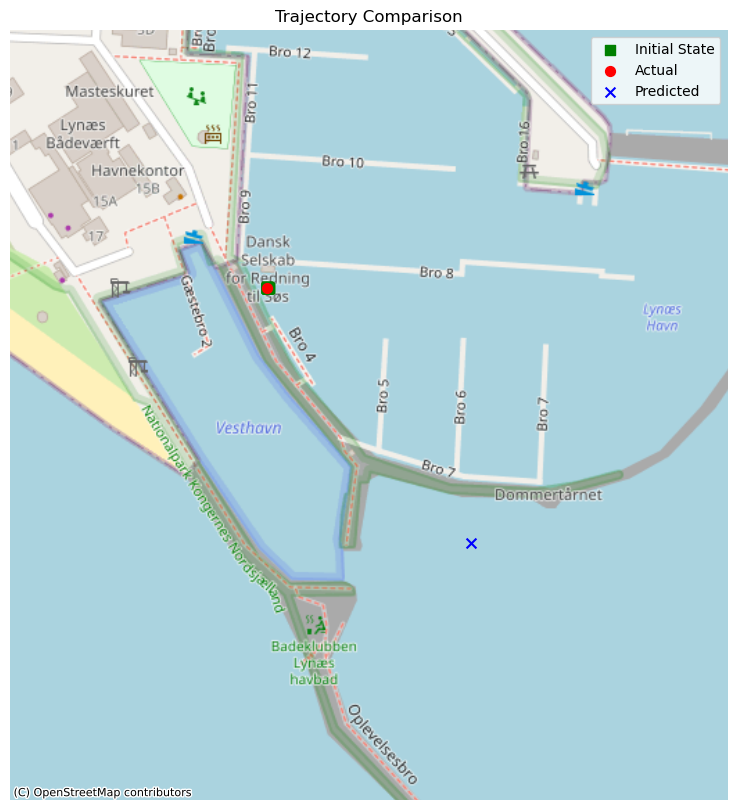

In [309]:
prediction_steps = 1

# Predict the test dataset
y_pred_scaled = model.predict(X_test)

# Assuming y_pred_scaled is now the prediction for the scaled Y values
# Inverse transform to get the original scale of lat and lon
y_pred_reshaped = y_pred_scaled.reshape(-1, 2)  # Reshape for scaler inverse transform
y_pred_inv = scaler.inverse_transform(y_pred_reshaped)  # Inverse transform to original scale
y_pred_inv = y_pred_inv.reshape(-1, prediction_steps, 2)  # Reshape back to the original prediction shape

# Prepare y_test similarly if not already in the correct shape and scale
y_test_reshaped = y_test.reshape(-1, 2)  # Reshape for scaler inverse transform
y_test_inv = scaler.inverse_transform(y_test_reshaped)  # Assuming y_test needs inverse transform
y_test_inv = y_test_inv.reshape(-1, prediction_steps, 2)  # Reshape back to original shape

X_test_lat_lon_scaled = X_test[:, :, 1:]  # Extract only latitude and longitude
X_test_lat_lon_inv = scaler.inverse_transform(X_test_lat_lon_scaled.reshape(-1, 2)).reshape(-1, X_test.shape[1], 2)

# Extracting the initial and final points for a single trajectory
single_pred = y_pred_inv[0]
single_actual = y_test_inv[0]
initial_state = X_test_lat_lon_inv[0]

# Convert to GeoDataFrame
gdf_pred = gpd.GeoDataFrame(geometry=gpd.points_from_xy(single_pred[:, 1], single_pred[:, 0]), crs="EPSG:4326")
gdf_actual = gpd.GeoDataFrame(geometry=gpd.points_from_xy(single_actual[:, 1], single_actual[:, 0]), crs="EPSG:4326")
gdf_initial = gpd.GeoDataFrame(geometry=gpd.points_from_xy(initial_state[:, 1], initial_state[:, 0]), crs="EPSG:4326")

# Plot
fig, ax = plt.subplots(figsize=(10, 10))

# Convert to Web Mercator
gdf_pred = gdf_pred.to_crs(epsg=3857)
gdf_actual = gdf_actual.to_crs(epsg=3857)
gdf_initial = gdf_initial.to_crs(epsg=3857)

# Plot initial points, actual trajectory, and predicted trajectory
gdf_initial.plot(ax=ax, marker='s', color='green', markersize=50, label='Initial State')
gdf_actual.plot(ax=ax, marker='o', color='red', markersize=50, label='Actual')
gdf_pred.plot(ax=ax, marker='x', color='blue', markersize=50, label='Predicted')

# Set the bounds for the plot
bounds_all = pd.concat([gdf_pred, gdf_actual, gdf_initial]).total_bounds
margin = 1 * max(bounds_all[2] - bounds_all[0], bounds_all[3] - bounds_all[1])
ax.set_xlim(bounds_all[0] - margin, bounds_all[2] + margin)
ax.set_ylim(bounds_all[1] - margin, bounds_all[3] + margin)

# Add basemap with auto zoom
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

# Set title and legend
ax.set_title('Trajectory Comparison')
ax.legend()

# Remove axis for better visualization
ax.set_axis_off()

plt.show()

In [290]:
# Calculate the metrics
rmse_lat = np.sqrt(mean_squared_error(y_test_inv[:, :, 0], y_pred_inv[:, :, 0]))
rmse_lon = np.sqrt(mean_squared_error(y_test_inv[:, :, 1], y_pred_inv[:, :, 1]))
mae_lat = mean_absolute_error(y_test_inv[:, :, 0], y_pred_inv[:, :, 0])
mae_lon = mean_absolute_error(y_test_inv[:, :, 1], y_pred_inv[:, :, 1])

# Assuming the scale of latitude and longitude is similar, you can calculate MAPE manually as it's not directly supported for multioutput by sklearn
mape_lat = np.mean(np.abs((y_test_inv[:, :, 0] - y_pred_inv[:, :, 0]) / y_test_inv[:, :, 0])) * 100
mape_lon = np.mean(np.abs((y_test_inv[:, :, 1] - y_pred_inv[:, :, 1]) / y_test_inv[:, :, 1])) * 100

# Append the metrics to the comparison dictionary
comparison["rmse"].append((rmse_lat + rmse_lon) / 2)  # Average RMSE for latitude and longitude
comparison["mae"].append((mae_lat + mae_lon) / 2)  # Average MAE for latitude and longitude
comparison["mape"].append((mape_lat + mape_lon) / 2)  #

In [291]:
# 30 to predict 10
import time

comparison["name"].append("MEOS")
timestr = ""

scaler = MinMaxScaler()

data =  traj_df.copy()
data['lon'] = traj_df['trajectory'].apply(lambda val: val.x)
data['lat'] = traj_df['trajectory'].apply(lambda val: val.y)

start = time.time()
data[['lat', 'lon']] = scaler.fit_transform(data[['lat', 'lon']])

train_df, test_df, val_df = get_train_test_val_split(data)

# Create dataset
X_train, y_train = create_sequences_meos(train_df, sequence_length=30, prediction_steps=10)
X_test, y_test = create_sequences_meos(test_df, sequence_length=30, prediction_steps=10)
X_val, y_val = create_sequences_meos(val_df, sequence_length=30, prediction_steps=10)

# # Prepare and train the model
start = time.time()

sequence_length = 10
prediction_features = 2

model = create_model(X_train.shape[1:], sequence_length, prediction_features)

model.compile(optimizer='adam', loss='mae')

# Note: No need to reshape y_train or y_val, as model output and targets are already aligned
model.fit(X_train, y_train, epochs=3, validation_data=(X_val, y_val))

end = time.time() - start
timestr += f' Training Time: {end} seconds'
comparison["time"].append(timestr)

Epoch 1/3
323/323 [==============================] - 10s 23ms/step - loss: 0.0862 - val_loss: 0.0521
Epoch 2/3
323/323 [==============================] - 6s 20ms/step - loss: 0.0240 - val_loss: 0.0319
Epoch 3/3
323/323 [==============================] - 6s 20ms/step - loss: 0.0192 - val_loss: 0.0261


108/108 [==============================] - 1s 8ms/step


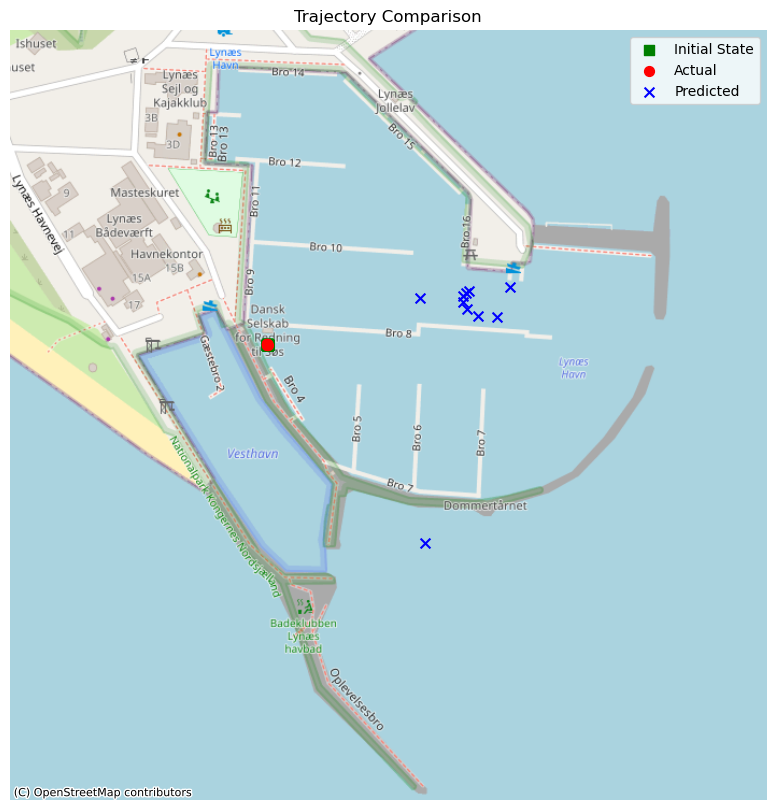

In [308]:
prediction_steps = 10

# Predict the test dataset
y_pred_scaled = model.predict(X_test)

# Assuming y_pred_scaled is now the prediction for the scaled Y values
# Inverse transform to get the original scale of lat and lon
y_pred_reshaped = y_pred_scaled.reshape(-1, 2)  # Reshape for scaler inverse transform
y_pred_inv = scaler.inverse_transform(y_pred_reshaped)  # Inverse transform to original scale
y_pred_inv = y_pred_inv.reshape(-1, prediction_steps, 2)  # Reshape back to the original prediction shape

# Prepare y_test similarly if not already in the correct shape and scale
y_test_reshaped = y_test.reshape(-1, 2)  # Reshape for scaler inverse transform
y_test_inv = scaler.inverse_transform(y_test_reshaped)  # Assuming y_test needs inverse transform
y_test_inv = y_test_inv.reshape(-1, prediction_steps, 2)  # Reshape back to original shape

X_test_lat_lon_scaled = X_test[:, :, 1:]  # Extract only latitude and longitude
X_test_lat_lon_inv = scaler.inverse_transform(X_test_lat_lon_scaled.reshape(-1, 2)).reshape(-1, X_test.shape[1], 2)

# Extracting the initial and final points for a single trajectory
single_pred = y_pred_inv[0]
single_actual = y_test_inv[0]
initial_state = X_test_lat_lon_inv[0]

# Convert to GeoDataFrame
gdf_pred = gpd.GeoDataFrame(geometry=gpd.points_from_xy(single_pred[:, 1], single_pred[:, 0]), crs="EPSG:4326")
gdf_actual = gpd.GeoDataFrame(geometry=gpd.points_from_xy(single_actual[:, 1], single_actual[:, 0]), crs="EPSG:4326")
gdf_initial = gpd.GeoDataFrame(geometry=gpd.points_from_xy(initial_state[:, 1], initial_state[:, 0]), crs="EPSG:4326")

# Plot
fig, ax = plt.subplots(figsize=(10, 10))

# Convert to Web Mercator
gdf_pred = gdf_pred.to_crs(epsg=3857)
gdf_actual = gdf_actual.to_crs(epsg=3857)
gdf_initial = gdf_initial.to_crs(epsg=3857)

# Plot initial points, actual trajectory, and predicted trajectory
gdf_initial.plot(ax=ax, marker='s', color='green', markersize=50, label='Initial State')
gdf_actual.plot(ax=ax, marker='o', color='red', markersize=50, label='Actual')
gdf_pred.plot(ax=ax, marker='x', color='blue', markersize=50, label='Predicted')

# Set the bounds for the plot
bounds_all = pd.concat([gdf_pred, gdf_actual, gdf_initial]).total_bounds
margin = 1 * max(bounds_all[2] - bounds_all[0], bounds_all[3] - bounds_all[1])
ax.set_xlim(bounds_all[0] - margin, bounds_all[2] + margin)
ax.set_ylim(bounds_all[1] - margin, bounds_all[3] + margin)

# Add basemap with auto zoom
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

# Set title and legend
ax.set_title('Trajectory Comparison')
ax.legend()

# Remove axis for better visualization
ax.set_axis_off()

plt.show()

In [293]:
# Calculate the metrics
rmse_lat = np.sqrt(mean_squared_error(y_test_inv[:, :, 0], y_pred_inv[:, :, 0]))
rmse_lon = np.sqrt(mean_squared_error(y_test_inv[:, :, 1], y_pred_inv[:, :, 1]))
mae_lat = mean_absolute_error(y_test_inv[:, :, 0], y_pred_inv[:, :, 0])
mae_lon = mean_absolute_error(y_test_inv[:, :, 1], y_pred_inv[:, :, 1])

# Assuming the scale of latitude and longitude is similar, you can calculate MAPE manually as it's not directly supported for multioutput by sklearn
mape_lat = np.mean(np.abs((y_test_inv[:, :, 0] - y_pred_inv[:, :, 0]) / y_test_inv[:, :, 0])) * 100
mape_lon = np.mean(np.abs((y_test_inv[:, :, 1] - y_pred_inv[:, :, 1]) / y_test_inv[:, :, 1])) * 100

# Append the metrics to the comparison dictionary
comparison["rmse"].append((rmse_lat + rmse_lon) / 2)  # Average RMSE for latitude and longitude
comparison["mae"].append((mae_lat + mae_lon) / 2)  # Average MAE for latitude and longitude
comparison["mape"].append((mape_lat + mape_lon) / 2)  #

In [298]:
# 30 to predict 30
import time

comparison["name"].append("MEOS")
timestr = ""

scaler = MinMaxScaler()

data =  traj_df.copy()
data['lon'] = traj_df['trajectory'].apply(lambda val: val.x)
data['lat'] = traj_df['trajectory'].apply(lambda val: val.y)

start = time.time()
data[['lat', 'lon']] = scaler.fit_transform(data[['lat', 'lon']])

train_df, test_df, val_df = get_train_test_val_split(data)

# Create dataset
X_train, y_train = create_sequences_meos(train_df, sequence_length=30, prediction_steps=30)
X_test, y_test = create_sequences_meos(test_df, sequence_length=30, prediction_steps=30)
X_val, y_val = create_sequences_meos(val_df, sequence_length=30, prediction_steps=30)

# # Prepare and train the model
start = time.time()

sequence_length = 30
prediction_features = 2

model = create_model(X_train.shape[1:], sequence_length, prediction_features)

model.compile(optimizer='adam', loss='mae')

# Note: No need to reshape y_train or y_val, as model output and targets are already aligned
model.fit(X_train, y_train, epochs=3, validation_data=(X_val, y_val))

end = time.time() - start
timestr += f' Training Time: {end} seconds'
comparison["time"].append(timestr)

Epoch 1/3
317/317 [==============================] - 11s 24ms/step - loss: 0.0811 - val_loss: 0.0549
Epoch 2/3
317/317 [==============================] - 7s 21ms/step - loss: 0.0256 - val_loss: 0.0470
Epoch 3/3
317/317 [==============================] - 7s 21ms/step - loss: 0.0204 - val_loss: 0.0836


108/108 [==============================] - 1s 8ms/step


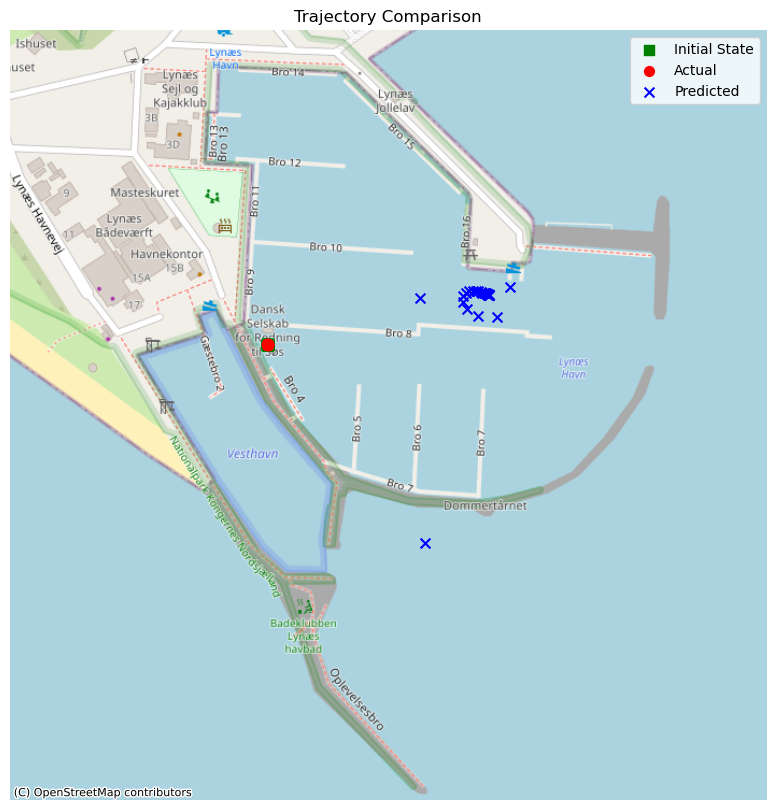

In [307]:
prediction_steps = 30

# Predict the test dataset
y_pred_scaled = model.predict(X_test)

# Assuming y_pred_scaled is now the prediction for the scaled Y values
# Inverse transform to get the original scale of lat and lon
y_pred_reshaped = y_pred_scaled.reshape(-1, 2)  # Reshape for scaler inverse transform
y_pred_inv = scaler.inverse_transform(y_pred_reshaped)  # Inverse transform to original scale
y_pred_inv = y_pred_inv.reshape(-1, prediction_steps, 2)  # Reshape back to the original prediction shape

# Prepare y_test similarly if not already in the correct shape and scale
y_test_reshaped = y_test.reshape(-1, 2)  # Reshape for scaler inverse transform
y_test_inv = scaler.inverse_transform(y_test_reshaped)  # Assuming y_test needs inverse transform
y_test_inv = y_test_inv.reshape(-1, prediction_steps, 2)  # Reshape back to original shape

X_test_lat_lon_scaled = X_test[:, :, 1:]  # Extract only latitude and longitude
X_test_lat_lon_inv = scaler.inverse_transform(X_test_lat_lon_scaled.reshape(-1, 2)).reshape(-1, X_test.shape[1], 2)

# Extracting the initial and final points for a single trajectory
single_pred = y_pred_inv[0]
single_actual = y_test_inv[0]
initial_state = X_test_lat_lon_inv[0]

# Convert to GeoDataFrame
gdf_pred = gpd.GeoDataFrame(geometry=gpd.points_from_xy(single_pred[:, 1], single_pred[:, 0]), crs="EPSG:4326")
gdf_actual = gpd.GeoDataFrame(geometry=gpd.points_from_xy(single_actual[:, 1], single_actual[:, 0]), crs="EPSG:4326")
gdf_initial = gpd.GeoDataFrame(geometry=gpd.points_from_xy(initial_state[:, 1], initial_state[:, 0]), crs="EPSG:4326")

# Plot
fig, ax = plt.subplots(figsize=(10, 10))

# Convert to Web Mercator
gdf_pred = gdf_pred.to_crs(epsg=3857)
gdf_actual = gdf_actual.to_crs(epsg=3857)
gdf_initial = gdf_initial.to_crs(epsg=3857)

# Plot initial points, actual trajectory, and predicted trajectory
gdf_initial.plot(ax=ax, marker='s', color='green', markersize=50, label='Initial State')
gdf_actual.plot(ax=ax, marker='o', color='red', markersize=50, label='Actual')
gdf_pred.plot(ax=ax, marker='x', color='blue', markersize=50, label='Predicted')

# Set the bounds for the plot
bounds_all = pd.concat([gdf_pred, gdf_actual, gdf_initial]).total_bounds
margin = 1 * max(bounds_all[2] - bounds_all[0], bounds_all[3] - bounds_all[1])
ax.set_xlim(bounds_all[0] - margin, bounds_all[2] + margin)
ax.set_ylim(bounds_all[1] - margin, bounds_all[3] + margin)

# Add basemap with auto zoom
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

# Set title and legend
ax.set_title('Trajectory Comparison')
ax.legend()

# Remove axis for better visualization
ax.set_axis_off()

plt.show()

In [301]:
# Calculate the metrics
rmse_lat = np.sqrt(mean_squared_error(y_test_inv[:, :, 0], y_pred_inv[:, :, 0]))
rmse_lon = np.sqrt(mean_squared_error(y_test_inv[:, :, 1], y_pred_inv[:, :, 1]))
mae_lat = mean_absolute_error(y_test_inv[:, :, 0], y_pred_inv[:, :, 0])
mae_lon = mean_absolute_error(y_test_inv[:, :, 1], y_pred_inv[:, :, 1])

# Assuming the scale of latitude and longitude is similar, you can calculate MAPE manually as it's not directly supported for multioutput by sklearn
mape_lat = np.mean(np.abs((y_test_inv[:, :, 0] - y_pred_inv[:, :, 0]) / y_test_inv[:, :, 0])) * 100
mape_lon = np.mean(np.abs((y_test_inv[:, :, 1] - y_pred_inv[:, :, 1]) / y_test_inv[:, :, 1])) * 100

# Append the metrics to the comparison dictionary
comparison["rmse"].append((rmse_lat + rmse_lon) / 2)  # Average RMSE for latitude and longitude
comparison["mae"].append((mae_lat + mae_lon) / 2)  # Average MAE for latitude and longitude
comparison["mape"].append((mape_lat + mape_lon) / 2)  #

In [306]:
comparison = pd.DataFrame(comparison)
pd.set_option('max_colwidth', 400)
comparison

,name,time,rmse,mape,mae
0,MovingPandas,Training Time: 46.030730962753296 seconds,0.011438,0.014525,0.002574
1,MEOS,Training Time: 23.818055152893066 seconds,0.015926,0.025051,0.004671
2,MEOS,Training Time: 23.763218641281128 seconds,0.025669,0.095735,0.012320
3,MEOS,Training Time: 24.525785207748413 seconds,0.030538,0.080826,0.010925


### Kalman Filter experiment

In [3]:
from filterpy.kalman import KalmanFilter
from filterpy.common import Q_discrete_white_noise
from pymeos import *
from tqdm.notebook import tqdm

import numpy as np
import pandas as pd
import contextily as cx

tqdm.pandas()
pymeos_initialize()

In [4]:
%%time
ais = pd.read_csv('./data/aisinput.csv')
ais.head()

ais.columns = ["t", "mmsi", "lat", "lon", "sog"]
ais = ais[ais["t"] != 0]
ais = ais[ais["mmsi"] != 0]
ais = ais.drop_duplicates(["t", "mmsi"])
ais = ais[(ais["lat"] >= 40.18) & (ais["lat"] <= 84.17)]
ais = ais[(ais["lon"] >= -16.1) & (ais["lon"] <= 32.88)]
ais = ais[(ais["sog"] >= 0) & (ais["sog"] <= 1022)]
ais.dropna()
ais.head()

CPU times: user 104 ms, sys: 15.2 ms, total: 120 ms
Wall time: 119 ms


,t,mmsi,lat,lon,sog
0,2021-01-08 00:00:00,265513270,57.05900,12.272388,0.0
1,2021-01-08 00:00:01,219027804,55.94244,11.866278,0.0
2,2021-01-08 00:00:01,265513270,57.05900,12.272388,0.0
3,2021-01-08 00:00:03,219027804,55.94244,11.866278,0.0
4,2021-01-08 00:00:04,265513270,57.05900,12.272388,0.0


In [5]:
ais["instant"] = ais.progress_apply(
    lambda row: TGeogPointInst(point=(row["lon"], row["lat"]), timestamp=row["t"]),
    axis=1,
)
ais["sog"] = ais.progress_apply(
    lambda row: TFloatInst(value=row["sog"], timestamp=row["t"]), axis=1
)


  0%|          | 0/156837 [00:00<?, ?it/s]

  0%|          | 0/156837 [00:00<?, ?it/s]

In [7]:
# ais.drop(["lat", "lon"], axis=1, inplace=True)
ais.head()

,t,mmsi,lat,lon,sog,instant
0,2021-01-08 00:00:00,265513270,57.05900,12.272388,0@2021-01-08 00:00:00+01,POINT(12.272388 57.059)@2021-01-08 00:00:00+01
1,2021-01-08 00:00:01,219027804,55.94244,11.866278,0@2021-01-08 00:00:01+01,POINT(11.866278 55.94244)@2021-01-08 00:00:01+01
2,2021-01-08 00:00:01,265513270,57.05900,12.272388,0@2021-01-08 00:00:01+01,POINT(12.272388 57.059)@2021-01-08 00:00:01+01
3,2021-01-08 00:00:03,219027804,55.94244,11.866278,0@2021-01-08 00:00:03+01,POINT(11.866278 55.94244)@2021-01-08 00:00:03+01
4,2021-01-08 00:00:04,265513270,57.05900,12.272388,0@2021-01-08 00:00:04+01,POINT(12.272388 57.059)@2021-01-08 00:00:04+01


In [8]:
trajectories = (
    ais.groupby("mmsi")
    .aggregate(
        {
            "instant": lambda x: TGeogPointSeq.from_instants(x, upper_inc=True),
            "sog": lambda x: TFloatSeq.from_instants(x, upper_inc=True),
        }
    )
    .rename({"instant": "trajectory"}, axis=1)
)
trajectories["distance"] = trajectories["trajectory"].apply(lambda t: t.length())
trajectories.head()

,trajectory,sog,distance
mmsi,,,
219001559,[POINT(9.975512 57.592245)@2021-01-08 00:00:05...,"[0.1@2021-01-08 00:00:05+01, 0.1@2021-01-08 00...",13762.269154
219027804,[POINT(11.866278 55.94244)@2021-01-08 00:00:01...,"[0@2021-01-08 00:00:01+01, 0@2021-01-08 00:34:...",67264.533216
257136000,[POINT(7.122958 56.911257)@2021-01-08 00:02:57...,"[14@2021-01-08 00:02:57+01, 13.9@2021-01-08 00...",647591.568588
265513270,[POINT(12.272388 57.059)@2021-01-08 00:00:00+0...,"[0@2021-01-08 00:00:00+01, 0@2021-01-08 00:00:...",1161.024274
566948000,[POINT(4.617153 55.574352)@2021-01-08 00:00:04...,"[0.5@2021-01-08 00:00:04+01, 0.5@2021-01-08 00...",20227.990689


In [15]:
df = ais[ais["mmsi"] == 219027804]
df.head()

,t,mmsi,lat,lon,sog,instant
1,2021-01-08 00:00:01,219027804,55.94244,11.866278,0@2021-01-08 00:00:01+01,POINT(11.866278 55.94244)@2021-01-08 00:00:01+01
3,2021-01-08 00:00:03,219027804,55.94244,11.866278,0@2021-01-08 00:00:03+01,POINT(11.866278 55.94244)@2021-01-08 00:00:03+01
7,2021-01-08 00:00:05,219027804,55.94244,11.866278,0@2021-01-08 00:00:05+01,POINT(11.866278 55.94244)@2021-01-08 00:00:05+01
9,2021-01-08 00:00:07,219027804,55.94244,11.866280,0@2021-01-08 00:00:07+01,POINT(11.86628 55.94244)@2021-01-08 00:00:07+01
12,2021-01-08 00:00:09,219027804,55.94244,11.866280,0@2021-01-08 00:00:09+01,POINT(11.86628 55.94244)@2021-01-08 00:00:09+01


In [22]:
# Define the Kalman Filter
kf = KalmanFilter(dim_x=4, dim_z=2)


initial_lon = df.iloc[0].lon
initial_lat = df.iloc[0].lat

# Define the initial state (position and velocity)
kf.x = np.array([initial_lon , initial_lat, 0, 0])

# Define the state transition matrix for constant velocity model
delta_t = 2  # Time step (1 second)
kf.F = np.array([[1, 0, delta_t, 0], 
                 [0, 1, 0, delta_t],
                 [0, 0, 1, 0],
                 [0, 0, 0, 1]])

# Define the measurement function
kf.H = np.array([[1, 0, 0, 0],
                 [0, 1, 0, 0]])

# Define the covariance matrix
kf.P = np.eye(4) * 1000 

# Define the process noise
kf.Q = Q_discrete_white_noise(dim=4, dt=delta_t, var=0.1)

# Define the measurement noise
kf.R = np.array([[0.1, 0],
                 [0, 0.1]])

predicted_positions = []
actual_positions = []

# Loop over your data, predict and update
for index, row in df.iterrows():
    # Predict the next state (without updating with measurement yet)
    kf.predict()
    
    # Here we get the predicted position from the state vector
    predicted_positions.append((kf.x[0], kf.x[1]))

    # Update the state with the current measurements
    kf.update(np.array([row['lon'], row['lat']]))
    
    # Here we store the actual position
    actual_positions.append((row['lon'], row['lat']))

# Convert the lists to numpy arrays for easier element-wise operations
predicted_positions = np.array(predicted_positions)
actual_positions = np.array(actual_positions)

# To calculate RMSE, collect predicted and actual positions
# Then use a function to calculate RMSE
def calculate_rmse(predictions, actuals):
    return np.sqrt(np.mean((predictions - actuals) ** 2, axis=0))

# Calculate RMSE for longitude and latitude separately
rmse_lon = calculate_rmse(predicted_positions[:, 0], actual_positions[:, 0])
rmse_lat = calculate_rmse(predicted_positions[:, 1], actual_positions[:, 1])

# Print out the RMSE values
print('RMSE Longitude:', rmse_lon)
print('RMSE Latitude:', rmse_lat)

RMSE Longitude: 0.06741237420266724
RMSE Latitude: 0.006487627245738516
